In [2]:
!unzip DATASET.zip

Archive:  DATASET.zip
   creating: DATASET/
  inflating: __MACOSX/._DATASET      
   creating: DATASET/TEST/
  inflating: __MACOSX/DATASET/._TEST  
   creating: DATASET/TRAIN/
  inflating: __MACOSX/DATASET/._TRAIN  
   creating: DATASET/TEST/downdog/
  inflating: __MACOSX/DATASET/TEST/._downdog  
   creating: DATASET/TEST/tree/
  inflating: __MACOSX/DATASET/TEST/._tree  
   creating: DATASET/TEST/warrior2/
  inflating: __MACOSX/DATASET/TEST/._warrior2  
   creating: DATASET/TEST/goddess/
  inflating: __MACOSX/DATASET/TEST/._goddess  
   creating: DATASET/TEST/plank/
  inflating: __MACOSX/DATASET/TEST/._plank  
   creating: DATASET/TRAIN/downdog/
  inflating: __MACOSX/DATASET/TRAIN/._downdog  
   creating: DATASET/TRAIN/tree/
  inflating: __MACOSX/DATASET/TRAIN/._tree  
   creating: DATASET/TRAIN/warrior2/
  inflating: __MACOSX/DATASET/TRAIN/._warrior2  
   creating: DATASET/TRAIN/goddess/
  inflating: __MACOSX/DATASET/TRAIN/._goddess  
   creating: DATASET/TRAIN/plank/
  inflating: __M

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from PIL import Image, ImageFile
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dir = "DATASET/TRAIN"
test_dir = "DATASET/TEST"

In [4]:
datagen_train = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.05
)

datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

test_gen = datagen_test.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_gen.num_classes
print("Classes:", num_classes)
print("Training:", train_gen.samples, "Validation:", val_gen.samples, "Test:", test_gen.samples)

Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.
Found 470 images belonging to 5 classes.
Classes: 5
Training: 866 Validation: 215 Test: 470


In [5]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0003),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,081,797 (11.76 MB)

 Trainable params: 822,277 (3.14 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [7]:
history_phase1 = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[reduce_lr, early_stop]
)

train_acc_p1 = history_phase1.history['accuracy'][-1]
val_acc_p1 = history_phase1.history['val_accuracy'][-1]
print("Phase 1 - Train: " + format(train_acc_p1*100, ".2f") + "%, Val: " + format(val_acc_p1*100, ".2f") + "%")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 8/28 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.3146 - loss: 3.2203 

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.2807 - loss: 3.2482 - val_accuracy: 0.3953 - val_loss: 2.4897 - learning_rate: 3.0000e-04
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 744ms/step - accuracy: 0.3516 - loss: 2.7942 - val_accuracy: 0.5302 - val_loss: 2.2335 - learning_rate: 3.0000e-04
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 713ms/step - accuracy: 0.4592 - loss: 2.4783 - val_accuracy: 0.6047 - val_loss: 2.0709 - learning_rate: 3.0000e-04
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 740ms/step - accuracy: 0.5520 - loss: 2.3199 - val_accuracy: 0.7767 - val_loss: 1.8384 - learning_rate: 3.0000e-04
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 739ms/step - accuracy: 0.6111 - loss: 2.1610 - val_accuracy: 0.8233 - val_loss: 1.7141 - learning_rate: 3.0000e-04
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 708ms/step - accuracy: 0.6489 - loss: 2.0771 - val_accuracy: 0.7674 - val_loss: 1.6922 - learning_rate: 3.0000e-04
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 730ms/step - accuracy: 0.6378 

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

count = 0
for layer in base_model.layers:
    if layer.trainable:
        count += 1

print("Unfrozen layers: " + str(count) + "\n")

Unfrozen layers: 30



In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[reduce_lr, early_stop]
)

train_acc_p2 = history_phase2.history['accuracy'][-1]
val_acc_p2 = history_phase2.history['val_accuracy'][-1]
print("\nPhase 2 - Train: " + format(train_acc_p2*100, ".2f") + "%, Val: " + format(val_acc_p2*100, ".2f") + "%")

print("Improvement: +" + format((val_acc_p2 - val_acc_p1)*100, ".2f") + "%")

history_combined = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6753 - loss: 1.9548 - val_accuracy: 0.7953 - val_loss: 1.6046 - learning_rate: 1.0000e-04
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 745ms/step - accuracy: 0.7712 - loss: 1.7005 - val_accuracy: 0.8279 - val_loss: 1.6333 - learning_rate: 1.0000e-04
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 748ms/step - accuracy: 0.7877 - loss: 1.6881 - val_accuracy: 0.8140 - val_loss: 1.6960 - learning_rate: 1.0000e-04
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.8077 - loss: 1.5779
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 718ms/step - accuracy: 0.8082 - loss: 1.5774 - val_accuracy: 0.7721 - val_loss: 1.7512 - learning_rate: 1.0000e-04
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 748ms/step - accuracy: 0.8147 - loss: 1.5461 - val_accuracy: 0.7953 - val_loss: 1.7267 - learning_rate: 5.0000e-05
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 747ms/step - accuracy: 0.

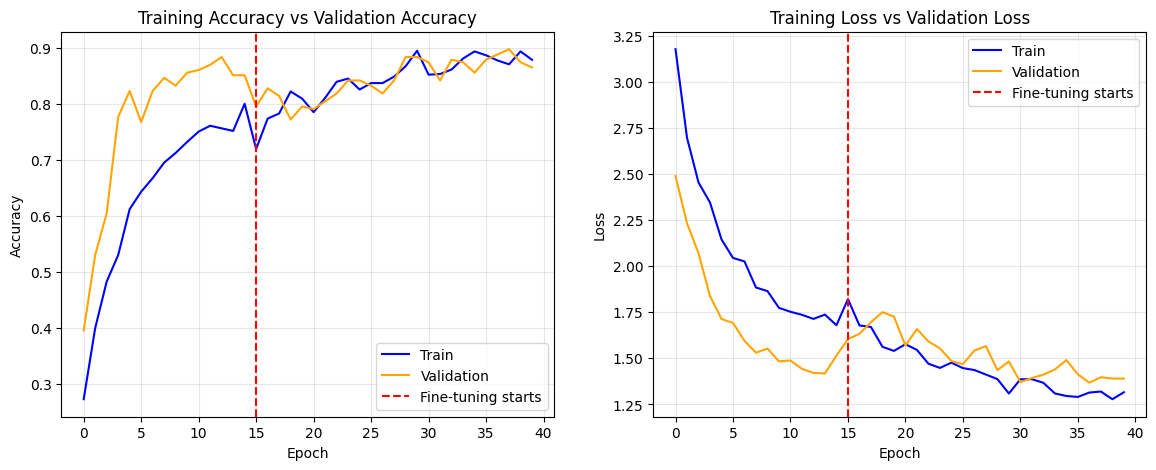

Final Evaluation
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 535ms/step - accuracy: 0.9284 - loss: 1.2221

Test accuracy: 93.62
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 541ms/step


In [11]:

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(history_combined['accuracy'], label='Train', color='blue')
ax[0].plot(history_combined['val_accuracy'], label='Validation', color='orange')
ax[0].axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--', label='Fine-tuning starts')
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='lower right')
ax[0].grid(True, alpha=0.3)

ax[1].plot(history_combined['loss'], label='Train', color='blue')
ax[1].plot(history_combined['val_loss'], label='Validation', color='orange')
ax[1].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', label='Fine-tuning starts')
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')
ax[1].grid(True, alpha=0.3)
plt.show()

print("Final Evaluation")

test_loss, test_acc = model.evaluate(test_gen)
print("\nTest accuracy:", format(test_acc*100, ".2f"))

test_gen.reset()
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(train_gen.class_indices.keys())


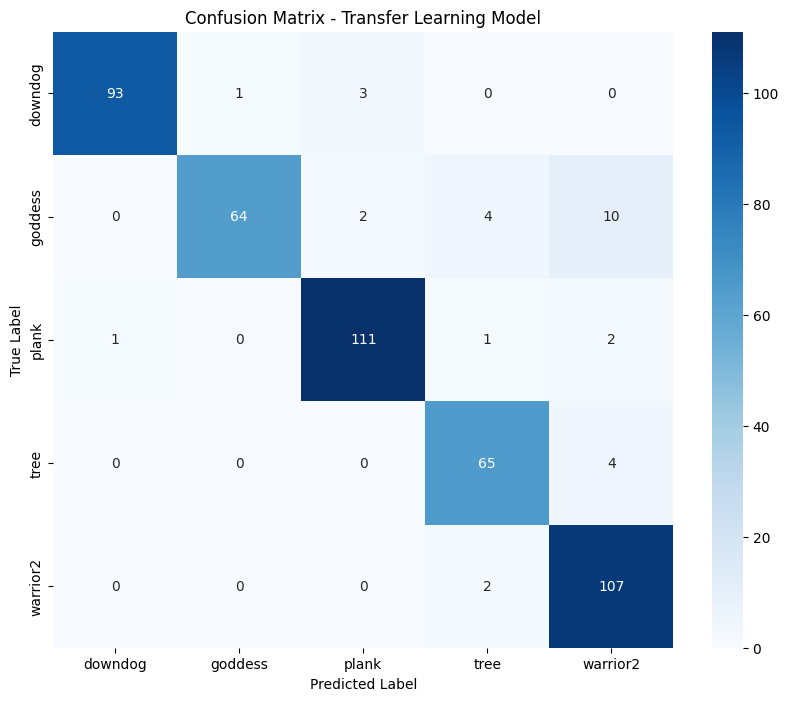

              precision    recall  f1-score   support

     downdog       0.99      0.96      0.97        97
     goddess       0.98      0.80      0.88        80
       plank       0.96      0.97      0.96       115
        tree       0.90      0.94      0.92        69
    warrior2       0.87      0.98      0.92       109

    accuracy                           0.94       470
   macro avg       0.94      0.93      0.93       470
weighted avg       0.94      0.94      0.94       470



In [12]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Transfer Learning Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

model.save('yoga_pose_final.h5')